In [1]:
import os
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [2]:
# setup pytorch gpu
print(torch.cuda.is_available())
print(torch.version.cuda)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

True
12.1


In [3]:
#load saved files
fname = 'processed/0_categories'

def file_loader(fname, reformat):
    """
    Loads saved data (in this specific project)
    """
    with open(f'./data/{fname}_x.pkl', 'rb') as f:
        firing_rates = pickle.load(f)
    with open(f'./data/{fname}_y.pkl', 'rb') as f:
        y_np = pickle.load(f)
    print(f'loaded data: X ({firing_rates.shape}), y ({y_np.shape})')
    
    num_cats = len(np.unique(y_np))

    if reformat:
        #format X as tensor of reordered dims to run CNNs
        firing_rates = torch.from_numpy(firing_rates).permute(2, 0, 1) 
        firing_rates = firing_rates.to(torch.float32)
        #format y as one hot encoding
        y = F.one_hot(torch.from_numpy(y_np).to(torch.int64))
        y = y.to(torch.float32)
    else:
        y = y_np

    return firing_rates, y, num_cats

firing_rates, y, num_cats = file_loader(fname, reformat=True)

loaded data: X ((15595, 93, 252)), y ((15595,))


In [4]:
#train test split
train_split = .8
all_ids = np.arange(firing_rates.shape[1])
np.random.shuffle(all_ids)
train_ids = all_ids[0:int(len(all_ids) * train_split)]
test_ids = all_ids[int(len(all_ids) * train_split):-1]

In [5]:
n_neurons = firing_rates.shape[-1] #number of units: size of input layer
n_bins = firing_rates.shape[0] #always 252 when defined as before
output_cats = num_cats #only two categories?

#param for dataloader
batch_size = 32

n_comps = 5 #n of latent comps to try
learning_rate = 1e-3 #big LR to converge quickly (hopefully)
lambda_l2 = 5e-3 #big l2 regularization
num_epochs = 20 #100 definitely enough, but after ~50 slows down considerably if lr=1e-4. 
#with lr=1e-3 10 might be enough
earlystop_criterion = 20 #how many iters of loss worsening before stopping

In [6]:
#define model architecture
class Net(nn.Module):
    def __init__(self, n_comps, n_neurons, output_cats):
        super(Net, self).__init__()
        
        #layers
        #1st conv -> relu -> maxpool block 
        #size: 
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 64, kernel_size = 3, stride = 2),
            nn.MaxPool2d(kernel_size = (2, 2), stride = 2)
        )
        #2nd conv -> relu -> maxpool block
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size = 3, stride = 2),
            nn.MaxPool2d(kernel_size = (2, 2), stride = 2)
        )

        # get the flattened size by using a dummy tensor of the same size
        dummy = torch.zeros(1, 1, n_bins, n_neurons)
        out = self.conv2(self.conv1(dummy))
        flattened_size = torch.flatten(out, 1).shape[1]

        #add a dropout layer
        self.dropout = nn.Dropout(p = 0.2)
        #1st fully connected layer for flattened data
        self.fc1 = nn.Linear(flattened_size, n_comps) #here, layer size depends on input data
        #2nd fully connected layer for dim reduction
        self.fc2 = nn.Linear(n_comps, output_cats)
    
    def forward(self, x):
        x = self.conv1(x)#conv
        x = self.conv2(x)#conv
        x = torch.flatten(x, 1) #flatten params
        x = self.dropout(x)
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        return x

In [7]:
class NeuralData(Dataset):
    def __init__(self, train = True):
        if train:
            self.firing_rate = firing_rates[:, train_ids, :]
            self.labels = y[train_ids]
        else:
            self.firing_rate = firing_rates[:, test_ids, :]
            self.labels = y[test_ids]
    
    def __len__(self):
        return self.labels.shape[0]

    def __getitem__(self, idx):
        rate = self.firing_rate[:, idx]
        # rate = torch.sum(self.firing_rate, axis = 0)[idx]
        label = self.labels[idx]
        return rate, label
    
train_data = NeuralData(train = True)
test_data = NeuralData(train = False)

train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(dataset = test_data, batch_size = batch_size, shuffle = False)

In [8]:
comps_to_try = [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25]
accs = []
losses = []

for n_comps in comps_to_try:
    train_data = NeuralData(train = True)
    test_data = NeuralData(train = False)

    train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True)
    test_loader = DataLoader(dataset = test_data, batch_size = batch_size, shuffle = False)
    #create model
    model = Net(n_comps = n_comps, n_neurons = n_neurons, output_cats = output_cats)

    #loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

    loss_list = []
    loss_increase = 0
    prev_loss = 5

    #train
    for epoch in tqdm.tqdm(range(num_epochs)):
        #iterate through train data
        for rate, label in train_loader:
            rate = rate.unsqueeze(1)
            #forward pass 
            pred = model(rate)
            
            l2 = 0
            for p in model.parameters():
                l2 += torch.sum(p ** 2)
            loss = criterion(pred, label) + lambda_l2 * l2
            loss_list.append(loss.item())
            
            #early stopping
            if loss > prev_loss:
                loss_increase += 1
                prev_loss = loss
                if loss_increase > earlystop_criterion:
                    print(f'Early stop at epoch {epoch}, loss = {loss}, didn\'t improve for {earlystop_criterion} iterations')            
            else:
                loss_increase = 0
                prev_loss = loss
                
            #backprop
            optimizer.zero_grad() #zero out grads
            loss.backward() #calculate grad
            optimizer.step() #take step

        print(f'epoch: {epoch}, loss: {loss}')
            
    # testing
    model.eval()
    model.to(device)
    real_labels, predicted_labels = [], []
    with torch.no_grad():
        correct = 0
        total = 0
        for rate, labels in test_loader:
            #load labels
            rate, labels = rate.to(device), labels.to(device)
            rate = rate.unsqueeze(1)
            val, labels = torch.max(labels.data, 1)
            real_labels += list(labels.cpu().numpy())
            #get preds
            preds = model(rate)
            val, predicted = torch.max(preds.data, 1)
            predicted_labels += list(predicted.cpu().numpy())
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accs.append((correct / total)*100)
        losses.append(loss_list)
        print(f"test acc from rates using {n_comps} hidden dims: {(correct / total)*100:.3f}%")

  5%|▌         | 1/20 [00:15<05:00, 15.80s/it]

epoch: 0, loss: 0.9803741574287415


 10%|█         | 2/20 [00:32<04:50, 16.16s/it]

epoch: 1, loss: 0.7093947529792786


 15%|█▌        | 3/20 [00:48<04:34, 16.17s/it]

epoch: 2, loss: 0.3065389096736908


 20%|██        | 4/20 [01:04<04:18, 16.16s/it]

epoch: 3, loss: 0.22074224054813385


 25%|██▌       | 5/20 [01:21<04:07, 16.48s/it]

epoch: 4, loss: 0.20601122081279755


 30%|███       | 6/20 [01:38<03:55, 16.79s/it]

epoch: 5, loss: 0.19601157307624817


 35%|███▌      | 7/20 [01:55<03:37, 16.72s/it]

epoch: 6, loss: 0.2622082531452179


 40%|████      | 8/20 [02:12<03:21, 16.81s/it]

epoch: 7, loss: 0.21987178921699524


 45%|████▌     | 9/20 [02:29<03:04, 16.82s/it]

epoch: 8, loss: 0.22474221885204315


 50%|█████     | 10/20 [02:46<02:47, 16.76s/it]

epoch: 9, loss: 0.18390251696109772


 55%|█████▌    | 11/20 [03:02<02:29, 16.67s/it]

epoch: 10, loss: 0.1968870609998703


 60%|██████    | 12/20 [03:18<02:12, 16.52s/it]

epoch: 11, loss: 0.22738948464393616


 65%|██████▌   | 13/20 [03:34<01:54, 16.34s/it]

epoch: 12, loss: 0.18474125862121582


 70%|███████   | 14/20 [03:50<01:37, 16.22s/it]

epoch: 13, loss: 0.1883440464735031


 75%|███████▌  | 15/20 [04:06<01:21, 16.28s/it]

epoch: 14, loss: 0.18444883823394775


 80%|████████  | 16/20 [04:23<01:05, 16.36s/it]

epoch: 15, loss: 0.20563754439353943


 85%|████████▌ | 17/20 [04:39<00:48, 16.27s/it]

epoch: 16, loss: 0.19051037728786469


 90%|█████████ | 18/20 [04:55<00:32, 16.20s/it]

epoch: 17, loss: 0.2187555581331253


 95%|█████████▌| 19/20 [05:11<00:16, 16.14s/it]

epoch: 18, loss: 0.2388802468776703


100%|██████████| 20/20 [05:27<00:00, 16.38s/it]

epoch: 19, loss: 0.2055576592683792


test acc from rates using 3 hidden dims: 99.455%


  5%|▌         | 1/20 [00:16<05:04, 16.04s/it]

epoch: 0, loss: 0.3717043399810791


 10%|█         | 2/20 [00:32<04:48, 16.01s/it]

epoch: 1, loss: 0.3859982192516327


 15%|█▌        | 3/20 [00:47<04:30, 15.94s/it]

epoch: 2, loss: 0.4757436513900757


 20%|██        | 4/20 [01:03<04:14, 15.91s/it]

epoch: 3, loss: 0.31405165791511536


 25%|██▌       | 5/20 [01:19<03:58, 15.93s/it]

epoch: 4, loss: 0.15204700827598572


 30%|███       | 6/20 [01:35<03:43, 15.95s/it]

epoch: 5, loss: 0.12653954327106476


 35%|███▌      | 7/20 [01:51<03:27, 15.96s/it]

epoch: 6, loss: 0.13660094141960144


 40%|████      | 8/20 [02:07<03:11, 15.93s/it]

epoch: 7, loss: 0.1141105443239212


 45%|████▌     | 9/20 [02:23<02:54, 15.86s/it]

epoch: 8, loss: 0.12023467570543289


 50%|█████     | 10/20 [02:39<02:38, 15.89s/it]

epoch: 9, loss: 0.1233169212937355


 55%|█████▌    | 11/20 [02:55<02:22, 15.88s/it]

epoch: 10, loss: 0.12521864473819733


 60%|██████    | 12/20 [03:10<02:06, 15.85s/it]

epoch: 11, loss: 0.12460503727197647


 65%|██████▌   | 13/20 [03:26<01:50, 15.84s/it]

epoch: 12, loss: 0.18470904231071472


 70%|███████   | 14/20 [03:42<01:35, 15.86s/it]

epoch: 13, loss: 0.15351960062980652


 75%|███████▌  | 15/20 [03:58<01:19, 15.84s/it]

epoch: 14, loss: 0.09912413358688354


 80%|████████  | 16/20 [04:14<01:03, 15.81s/it]

epoch: 15, loss: 0.11331124603748322


 85%|████████▌ | 17/20 [04:30<00:47, 15.87s/it]

epoch: 16, loss: 0.10920900106430054


 90%|█████████ | 18/20 [04:45<00:31, 15.79s/it]

epoch: 17, loss: 0.11258827149868011


 95%|█████████▌| 19/20 [04:59<00:15, 15.33s/it]

epoch: 18, loss: 0.14211513102054596


100%|██████████| 20/20 [05:14<00:00, 15.71s/it]

epoch: 19, loss: 0.10328908264636993


test acc from rates using 5 hidden dims: 99.230%


  5%|▌         | 1/20 [00:14<04:34, 14.46s/it]

epoch: 0, loss: 0.2453756034374237


 10%|█         | 2/20 [00:28<04:20, 14.44s/it]

epoch: 1, loss: 0.21881122887134552


 15%|█▌        | 3/20 [00:43<04:04, 14.41s/it]

epoch: 2, loss: 0.22312545776367188


 20%|██        | 4/20 [00:57<03:50, 14.38s/it]

epoch: 3, loss: 0.12120114266872406


 25%|██▌       | 5/20 [01:11<03:35, 14.39s/it]

epoch: 4, loss: 0.11900301277637482


 30%|███       | 6/20 [01:26<03:21, 14.39s/it]

epoch: 5, loss: 0.1959574818611145


 35%|███▌      | 7/20 [01:40<03:07, 14.39s/it]

epoch: 6, loss: 0.11900205910205841


 40%|████      | 8/20 [01:55<02:52, 14.34s/it]

epoch: 7, loss: 0.1096995547413826


 45%|████▌     | 9/20 [02:09<02:37, 14.32s/it]

epoch: 8, loss: 0.10240618139505386


 50%|█████     | 10/20 [02:24<02:25, 14.52s/it]

epoch: 9, loss: 0.2087850570678711


 55%|█████▌    | 11/20 [02:39<02:13, 14.83s/it]

epoch: 10, loss: 0.10919108241796494


 60%|██████    | 12/20 [02:54<01:59, 14.92s/it]

epoch: 11, loss: 0.1054852232336998


 65%|██████▌   | 13/20 [03:10<01:45, 15.14s/it]

epoch: 12, loss: 0.19439679384231567


 70%|███████   | 14/20 [03:26<01:31, 15.30s/it]

epoch: 13, loss: 0.10758975148200989


 75%|███████▌  | 15/20 [03:42<01:18, 15.68s/it]

epoch: 14, loss: 0.10764110833406448


 80%|████████  | 16/20 [03:59<01:03, 15.92s/it]

epoch: 15, loss: 0.15463605523109436


 85%|████████▌ | 17/20 [04:15<00:48, 16.13s/it]

epoch: 16, loss: 0.28789395093917847


 90%|█████████ | 18/20 [04:32<00:32, 16.30s/it]

epoch: 17, loss: 0.09951981157064438


 95%|█████████▌| 19/20 [04:49<00:16, 16.35s/it]

epoch: 18, loss: 0.11125966161489487


100%|██████████| 20/20 [05:05<00:00, 15.28s/it]

epoch: 19, loss: 0.14752495288848877


test acc from rates using 7 hidden dims: 99.743%


  5%|▌         | 1/20 [00:16<05:17, 16.69s/it]

epoch: 0, loss: 0.19326505064964294


 10%|█         | 2/20 [00:33<05:00, 16.70s/it]

epoch: 1, loss: 0.14939667284488678


 15%|█▌        | 3/20 [00:49<04:42, 16.61s/it]

epoch: 2, loss: 0.15108348429203033


 20%|██        | 4/20 [01:06<04:25, 16.59s/it]

epoch: 3, loss: 0.12656255066394806


 25%|██▌       | 5/20 [01:22<04:07, 16.53s/it]

epoch: 4, loss: 0.1118532195687294


 30%|███       | 6/20 [01:39<03:51, 16.51s/it]

epoch: 5, loss: 0.12835538387298584


 35%|███▌      | 7/20 [01:55<03:34, 16.50s/it]

epoch: 6, loss: 0.13995395600795746


 40%|████      | 8/20 [02:12<03:18, 16.51s/it]

epoch: 7, loss: 0.1099865585565567


 45%|████▌     | 9/20 [02:28<03:01, 16.53s/it]

epoch: 8, loss: 0.1107921451330185


 50%|█████     | 10/20 [02:45<02:44, 16.48s/it]

epoch: 9, loss: 0.1327931433916092


 55%|█████▌    | 11/20 [03:01<02:27, 16.37s/it]

epoch: 10, loss: 0.10360836982727051


 60%|██████    | 12/20 [03:17<02:09, 16.24s/it]

epoch: 11, loss: 0.11868396401405334


 65%|██████▌   | 13/20 [03:33<01:52, 16.13s/it]

epoch: 12, loss: 0.10826152563095093


 70%|███████   | 14/20 [03:49<01:36, 16.05s/it]

epoch: 13, loss: 0.11367195099592209


 75%|███████▌  | 15/20 [04:04<01:19, 15.97s/it]

epoch: 14, loss: 0.1521838903427124


 80%|████████  | 16/20 [04:20<01:03, 15.92s/it]

epoch: 15, loss: 0.10705181211233139


 85%|████████▌ | 17/20 [04:36<00:47, 15.89s/it]

epoch: 16, loss: 0.10374857485294342


 90%|█████████ | 18/20 [04:52<00:31, 15.85s/it]

epoch: 17, loss: 0.11465863883495331


 95%|█████████▌| 19/20 [05:08<00:15, 15.83s/it]

epoch: 18, loss: 0.11232335865497589


100%|██████████| 20/20 [05:23<00:00, 16.20s/it]

epoch: 19, loss: 0.12333336472511292


test acc from rates using 9 hidden dims: 99.647%


  5%|▌         | 1/20 [00:15<04:53, 15.42s/it]

epoch: 0, loss: 0.22283795475959778


 10%|█         | 2/20 [00:29<04:24, 14.72s/it]

epoch: 1, loss: 0.13612371683120728


 15%|█▌        | 3/20 [00:43<04:06, 14.50s/it]

epoch: 2, loss: 0.1635160595178604


 20%|██        | 4/20 [00:58<03:49, 14.36s/it]

epoch: 3, loss: 0.14117664098739624


 25%|██▌       | 5/20 [01:12<03:34, 14.31s/it]

epoch: 4, loss: 0.2068977653980255


 30%|███       | 6/20 [01:26<03:19, 14.27s/it]

epoch: 5, loss: 0.1348169445991516


 35%|███▌      | 7/20 [01:40<03:05, 14.26s/it]

epoch: 6, loss: 0.1130652204155922


 40%|████      | 8/20 [01:54<02:50, 14.24s/it]

epoch: 7, loss: 0.10706616193056107


 45%|████▌     | 9/20 [02:09<02:36, 14.23s/it]

epoch: 8, loss: 0.11183148622512817


 50%|█████     | 10/20 [02:23<02:22, 14.23s/it]

epoch: 9, loss: 0.10900811851024628


 55%|█████▌    | 11/20 [02:37<02:07, 14.21s/it]

epoch: 10, loss: 0.11873023957014084


 60%|██████    | 12/20 [02:51<01:53, 14.21s/it]

epoch: 11, loss: 0.10688508301973343


 65%|██████▌   | 13/20 [03:05<01:39, 14.22s/it]

epoch: 12, loss: 0.10153903812170029


 70%|███████   | 14/20 [03:20<01:25, 14.20s/it]

epoch: 13, loss: 0.10978174209594727


 75%|███████▌  | 15/20 [03:34<01:11, 14.21s/it]

epoch: 14, loss: 0.11373019218444824


 80%|████████  | 16/20 [03:48<00:56, 14.22s/it]

epoch: 15, loss: 0.11248786747455597


 85%|████████▌ | 17/20 [04:02<00:42, 14.21s/it]

epoch: 16, loss: 0.14901308715343475


 90%|█████████ | 18/20 [04:17<00:28, 14.41s/it]

epoch: 17, loss: 0.10502535849809647


 95%|█████████▌| 19/20 [04:33<00:14, 14.86s/it]

epoch: 18, loss: 0.11468421667814255


100%|██████████| 20/20 [04:49<00:00, 14.47s/it]

epoch: 19, loss: 0.10593807697296143


test acc from rates using 11 hidden dims: 99.647%


  5%|▌         | 1/20 [00:16<05:05, 16.10s/it]

epoch: 0, loss: 0.29113778471946716


 10%|█         | 2/20 [00:31<04:46, 15.93s/it]

epoch: 1, loss: 0.14930394291877747


 15%|█▌        | 3/20 [00:47<04:30, 15.89s/it]

epoch: 2, loss: 0.19844910502433777


 20%|██        | 4/20 [01:03<04:13, 15.85s/it]

epoch: 3, loss: 0.10861089825630188


 25%|██▌       | 5/20 [01:19<03:57, 15.85s/it]

epoch: 4, loss: 0.12770885229110718


 30%|███       | 6/20 [01:35<03:41, 15.82s/it]

epoch: 5, loss: 0.10783527791500092


 35%|███▌      | 7/20 [01:51<03:26, 15.86s/it]

epoch: 6, loss: 0.1112060546875


 40%|████      | 8/20 [02:07<03:10, 15.88s/it]

epoch: 7, loss: 0.12286965548992157


 45%|████▌     | 9/20 [02:22<02:54, 15.89s/it]

epoch: 8, loss: 0.10483347624540329


 50%|█████     | 10/20 [02:38<02:38, 15.88s/it]

epoch: 9, loss: 0.11262604594230652


 55%|█████▌    | 11/20 [02:54<02:22, 15.88s/it]

epoch: 10, loss: 0.10719668865203857


 60%|██████    | 12/20 [03:10<02:07, 15.89s/it]

epoch: 11, loss: 0.10691944509744644


 65%|██████▌   | 13/20 [03:26<01:51, 15.87s/it]

epoch: 12, loss: 0.10562775284051895


 70%|███████   | 14/20 [03:42<01:36, 16.02s/it]

epoch: 13, loss: 0.10713685303926468


 75%|███████▌  | 15/20 [03:58<01:20, 16.07s/it]

epoch: 14, loss: 0.11283059418201447


 80%|████████  | 16/20 [04:15<01:05, 16.27s/it]

epoch: 15, loss: 0.10886213928461075


 85%|████████▌ | 17/20 [04:32<00:49, 16.35s/it]

epoch: 16, loss: 0.11122004687786102


 90%|█████████ | 18/20 [04:48<00:32, 16.40s/it]

epoch: 17, loss: 0.11371933668851852


 95%|█████████▌| 19/20 [05:05<00:16, 16.42s/it]

epoch: 18, loss: 0.11258380115032196


100%|██████████| 20/20 [05:21<00:00, 16.08s/it]

epoch: 19, loss: 0.10344474762678146


test acc from rates using 13 hidden dims: 99.583%


  5%|▌         | 1/20 [00:16<05:21, 16.92s/it]

epoch: 0, loss: 0.38675394654273987


 10%|█         | 2/20 [00:33<05:05, 16.95s/it]

epoch: 1, loss: 0.1557013988494873


 15%|█▌        | 3/20 [00:50<04:48, 16.95s/it]

epoch: 2, loss: 0.19990064203739166


 20%|██        | 4/20 [01:07<04:30, 16.93s/it]

epoch: 3, loss: 0.13020122051239014


 25%|██▌       | 5/20 [01:24<04:12, 16.86s/it]

epoch: 4, loss: 0.13242200016975403


 30%|███       | 6/20 [01:41<03:55, 16.82s/it]

epoch: 5, loss: 0.13448546826839447


 35%|███▌      | 7/20 [01:57<03:38, 16.78s/it]

epoch: 6, loss: 0.1414048671722412


 40%|████      | 8/20 [02:14<03:21, 16.76s/it]

epoch: 7, loss: 0.3456510305404663


 45%|████▌     | 9/20 [02:31<03:04, 16.80s/it]

epoch: 8, loss: 0.10812122374773026


 50%|█████     | 10/20 [02:48<02:48, 16.83s/it]

epoch: 9, loss: 0.12791377305984497


 55%|█████▌    | 11/20 [03:05<02:31, 16.84s/it]

epoch: 10, loss: 0.16737692058086395


 60%|██████    | 12/20 [03:22<02:14, 16.87s/it]

epoch: 11, loss: 0.11105677485466003


 65%|██████▌   | 13/20 [03:39<01:58, 16.88s/it]

epoch: 12, loss: 0.10832085460424423


 70%|███████   | 14/20 [03:55<01:41, 16.85s/it]

epoch: 13, loss: 0.1195865347981453


 75%|███████▌  | 15/20 [04:12<01:24, 16.82s/it]

epoch: 14, loss: 0.11705972254276276


 80%|████████  | 16/20 [04:29<01:07, 16.81s/it]

epoch: 15, loss: 0.1176922619342804


 85%|████████▌ | 17/20 [04:46<00:50, 16.82s/it]

epoch: 16, loss: 0.1089758425951004


 90%|█████████ | 18/20 [05:03<00:33, 16.82s/it]

epoch: 17, loss: 0.10257995128631592


 95%|█████████▌| 19/20 [05:19<00:16, 16.73s/it]

epoch: 18, loss: 0.25956425070762634


100%|██████████| 20/20 [05:35<00:00, 16.80s/it]

epoch: 19, loss: 0.11495400965213776


test acc from rates using 15 hidden dims: 99.455%


  5%|▌         | 1/20 [00:16<05:14, 16.57s/it]

epoch: 0, loss: 0.21839427947998047


 10%|█         | 2/20 [00:32<04:56, 16.48s/it]

epoch: 1, loss: 0.1445871740579605


 15%|█▌        | 3/20 [00:49<04:38, 16.40s/it]

epoch: 2, loss: 0.13915301859378815


 20%|██        | 4/20 [01:05<04:21, 16.35s/it]

epoch: 3, loss: 0.11129222810268402


 25%|██▌       | 5/20 [01:21<04:05, 16.35s/it]

epoch: 4, loss: 0.11014804989099503


 30%|███       | 6/20 [01:38<03:48, 16.33s/it]

epoch: 5, loss: 0.13990579545497894


 35%|███▌      | 7/20 [01:54<03:32, 16.31s/it]

epoch: 6, loss: 0.12420612573623657


 40%|████      | 8/20 [02:10<03:16, 16.33s/it]

epoch: 7, loss: 0.11403690278530121


 45%|████▌     | 9/20 [02:27<02:59, 16.32s/it]

epoch: 8, loss: 0.11441048979759216


 50%|█████     | 10/20 [02:43<02:43, 16.34s/it]

epoch: 9, loss: 0.1582164168357849


 55%|█████▌    | 11/20 [02:59<02:26, 16.31s/it]

epoch: 10, loss: 0.099614717066288


 60%|██████    | 12/20 [03:16<02:10, 16.33s/it]

epoch: 11, loss: 0.12233926355838776


 65%|██████▌   | 13/20 [03:32<01:54, 16.31s/it]

epoch: 12, loss: 0.10651170462369919


 70%|███████   | 14/20 [03:48<01:37, 16.28s/it]

epoch: 13, loss: 0.10909046977758408


 75%|███████▌  | 15/20 [04:04<01:21, 16.27s/it]

epoch: 14, loss: 0.12465385347604752


 80%|████████  | 16/20 [04:21<01:05, 16.28s/it]

epoch: 15, loss: 0.11634152382612228


 85%|████████▌ | 17/20 [04:37<00:48, 16.26s/it]

epoch: 16, loss: 0.11790107935667038


 90%|█████████ | 18/20 [04:53<00:32, 16.25s/it]

epoch: 17, loss: 0.10223379731178284


 95%|█████████▌| 19/20 [05:09<00:16, 16.26s/it]

epoch: 18, loss: 0.11583468317985535


100%|██████████| 20/20 [05:26<00:00, 16.31s/it]

epoch: 19, loss: 0.11724455654621124


test acc from rates using 17 hidden dims: 99.679%


  5%|▌         | 1/20 [00:16<05:12, 16.45s/it]

epoch: 0, loss: 0.18731310963630676


 10%|█         | 2/20 [00:32<04:54, 16.38s/it]

epoch: 1, loss: 0.1552811712026596


 15%|█▌        | 3/20 [00:49<04:37, 16.33s/it]

epoch: 2, loss: 0.13715358078479767


 20%|██        | 4/20 [01:05<04:20, 16.31s/it]

epoch: 3, loss: 0.16224995255470276


 25%|██▌       | 5/20 [01:21<04:04, 16.31s/it]

epoch: 4, loss: 0.173908531665802


 30%|███       | 6/20 [01:37<03:47, 16.26s/it]

epoch: 5, loss: 0.12349680066108704


 35%|███▌      | 7/20 [01:54<03:31, 16.30s/it]

epoch: 6, loss: 0.11343959718942642


 40%|████      | 8/20 [02:10<03:15, 16.31s/it]

epoch: 7, loss: 0.12976592779159546


 45%|████▌     | 9/20 [02:26<02:59, 16.32s/it]

epoch: 8, loss: 0.10406289994716644


 50%|█████     | 10/20 [02:43<02:43, 16.31s/it]

epoch: 9, loss: 0.11415968090295792


 55%|█████▌    | 11/20 [02:59<02:26, 16.33s/it]

epoch: 10, loss: 0.11253747344017029


 60%|██████    | 12/20 [03:15<02:10, 16.33s/it]

epoch: 11, loss: 0.12556202709674835


 65%|██████▌   | 13/20 [03:32<01:54, 16.32s/it]

epoch: 12, loss: 0.12892189621925354


 70%|███████   | 14/20 [03:48<01:38, 16.34s/it]

epoch: 13, loss: 0.1115468218922615


 75%|███████▌  | 15/20 [04:05<01:22, 16.45s/it]

epoch: 14, loss: 0.11499562114477158


 80%|████████  | 16/20 [04:22<01:06, 16.57s/it]

epoch: 15, loss: 0.1099126935005188


 85%|████████▌ | 17/20 [04:39<00:50, 16.94s/it]

epoch: 16, loss: 0.1377650499343872


 90%|█████████ | 18/20 [04:56<00:33, 16.95s/it]

epoch: 17, loss: 0.13348813354969025


 95%|█████████▌| 19/20 [05:14<00:17, 17.07s/it]

epoch: 18, loss: 0.10517460107803345


100%|██████████| 20/20 [05:31<00:00, 16.56s/it]

epoch: 19, loss: 0.10423515737056732


test acc from rates using 19 hidden dims: 99.583%


  5%|▌         | 1/20 [00:17<05:26, 17.19s/it]

epoch: 0, loss: 0.18292635679244995


 10%|█         | 2/20 [00:34<05:08, 17.12s/it]

epoch: 1, loss: 0.18513888120651245


 15%|█▌        | 3/20 [00:51<04:49, 17.06s/it]

epoch: 2, loss: 0.12288221716880798


 20%|██        | 4/20 [01:07<04:28, 16.81s/it]

epoch: 3, loss: 0.11718054115772247


 25%|██▌       | 5/20 [01:24<04:11, 16.75s/it]

epoch: 4, loss: 0.12394339591264725


 30%|███       | 6/20 [01:40<03:52, 16.61s/it]

epoch: 5, loss: 0.12548129260540009


 35%|███▌      | 7/20 [01:57<03:35, 16.59s/it]

epoch: 6, loss: 0.11915574967861176


 40%|████      | 8/20 [02:13<03:18, 16.50s/it]

epoch: 7, loss: 0.14490275084972382


 45%|████▌     | 9/20 [02:29<03:01, 16.49s/it]

epoch: 8, loss: 0.1068381816148758


 50%|█████     | 10/20 [02:46<02:44, 16.47s/it]

epoch: 9, loss: 0.10529307276010513


 55%|█████▌    | 11/20 [03:02<02:28, 16.45s/it]

epoch: 10, loss: 0.10726534575223923


 60%|██████    | 12/20 [03:19<02:11, 16.47s/it]

epoch: 11, loss: 0.14778974652290344


 65%|██████▌   | 13/20 [03:35<01:55, 16.50s/it]

epoch: 12, loss: 0.12100086361169815


 70%|███████   | 14/20 [03:52<01:38, 16.46s/it]

epoch: 13, loss: 0.1946367621421814


 75%|███████▌  | 15/20 [04:08<01:22, 16.42s/it]

epoch: 14, loss: 0.12515892088413239


 80%|████████  | 16/20 [04:24<01:05, 16.40s/it]

epoch: 15, loss: 0.11327125132083893


 85%|████████▌ | 17/20 [04:41<00:49, 16.39s/it]

epoch: 16, loss: 0.11626427620649338


 90%|█████████ | 18/20 [04:57<00:32, 16.34s/it]

epoch: 17, loss: 0.1211981400847435


 95%|█████████▌| 19/20 [05:13<00:16, 16.35s/it]

epoch: 18, loss: 0.12692300975322723


100%|██████████| 20/20 [05:30<00:00, 16.52s/it]

epoch: 19, loss: 0.12941379845142365


test acc from rates using 21 hidden dims: 99.583%


  5%|▌         | 1/20 [00:16<05:14, 16.57s/it]

epoch: 0, loss: 0.18300676345825195


 10%|█         | 2/20 [00:33<04:57, 16.53s/it]

epoch: 1, loss: 0.31223392486572266


 15%|█▌        | 3/20 [00:49<04:39, 16.47s/it]

epoch: 2, loss: 0.11955101788043976


 20%|██        | 4/20 [01:05<04:22, 16.41s/it]

epoch: 3, loss: 0.13041925430297852


 25%|██▌       | 5/20 [01:22<04:06, 16.42s/it]

epoch: 4, loss: 0.17287848889827728


 30%|███       | 6/20 [01:38<03:49, 16.41s/it]

epoch: 5, loss: 0.1862826943397522


 35%|███▌      | 7/20 [01:55<03:33, 16.43s/it]

epoch: 6, loss: 0.22388145327568054


 40%|████      | 8/20 [02:11<03:17, 16.44s/it]

epoch: 7, loss: 0.12478090822696686


 45%|████▌     | 9/20 [02:27<03:00, 16.43s/it]

epoch: 8, loss: 0.10518154501914978


 50%|█████     | 10/20 [02:44<02:43, 16.40s/it]

epoch: 9, loss: 0.1397799253463745


 55%|█████▌    | 11/20 [03:00<02:27, 16.37s/it]

epoch: 10, loss: 0.10724674165248871


 60%|██████    | 12/20 [03:16<02:10, 16.33s/it]

epoch: 11, loss: 0.11459700018167496


 65%|██████▌   | 13/20 [03:33<01:54, 16.29s/it]

epoch: 12, loss: 0.13738152384757996


 70%|███████   | 14/20 [03:49<01:38, 16.36s/it]

epoch: 13, loss: 0.22504858672618866


 75%|███████▌  | 15/20 [04:05<01:21, 16.34s/it]

epoch: 14, loss: 0.11165127903223038


 80%|████████  | 16/20 [04:22<01:05, 16.35s/it]

epoch: 15, loss: 0.14309819042682648


 85%|████████▌ | 17/20 [04:38<00:49, 16.39s/it]

epoch: 16, loss: 0.12954068183898926


 90%|█████████ | 18/20 [04:55<00:32, 16.41s/it]

epoch: 17, loss: 0.10919005423784256


 95%|█████████▌| 19/20 [05:11<00:16, 16.40s/it]

epoch: 18, loss: 0.10766009986400604


100%|██████████| 20/20 [05:27<00:00, 16.40s/it]

epoch: 19, loss: 0.10970931500196457


test acc from rates using 23 hidden dims: 99.455%


  5%|▌         | 1/20 [00:16<05:14, 16.54s/it]

epoch: 0, loss: 0.18610656261444092


 10%|█         | 2/20 [00:32<04:56, 16.47s/it]

epoch: 1, loss: 0.1302979737520218


 15%|█▌        | 3/20 [00:49<04:40, 16.48s/it]

epoch: 2, loss: 0.17563220858573914


 20%|██        | 4/20 [01:05<04:23, 16.44s/it]

epoch: 3, loss: 0.11675547808408737


 25%|██▌       | 5/20 [01:22<04:06, 16.41s/it]

epoch: 4, loss: 0.11905194073915482


 30%|███       | 6/20 [01:38<03:49, 16.39s/it]

epoch: 5, loss: 0.24070890247821808


 35%|███▌      | 7/20 [01:54<03:33, 16.39s/it]

epoch: 6, loss: 0.12325123697519302


 40%|████      | 8/20 [02:11<03:16, 16.37s/it]

epoch: 7, loss: 0.11675228923559189


 45%|████▌     | 9/20 [02:27<02:59, 16.36s/it]

epoch: 8, loss: 0.11321680247783661


 50%|█████     | 10/20 [02:44<02:43, 16.38s/it]

epoch: 9, loss: 0.11417210102081299


 55%|█████▌    | 11/20 [03:00<02:27, 16.37s/it]

epoch: 10, loss: 0.12549233436584473


 60%|██████    | 12/20 [03:16<02:10, 16.36s/it]

epoch: 11, loss: 0.10512029379606247


 65%|██████▌   | 13/20 [03:33<01:54, 16.38s/it]

epoch: 12, loss: 0.11592216789722443


 70%|███████   | 14/20 [03:49<01:38, 16.40s/it]

epoch: 13, loss: 0.10991276800632477


 75%|███████▌  | 15/20 [04:05<01:21, 16.38s/it]

epoch: 14, loss: 0.12364020943641663


 80%|████████  | 16/20 [04:22<01:05, 16.42s/it]

epoch: 15, loss: 0.10571183264255524


 85%|████████▌ | 17/20 [04:38<00:49, 16.41s/it]

epoch: 16, loss: 0.12771141529083252


 90%|█████████ | 18/20 [04:55<00:32, 16.42s/it]

epoch: 17, loss: 0.1366444081068039


 95%|█████████▌| 19/20 [05:11<00:16, 16.41s/it]

epoch: 18, loss: 0.24422037601470947


100%|██████████| 20/20 [05:28<00:00, 16.40s/it]

epoch: 19, loss: 0.10819398611783981


test acc from rates using 25 hidden dims: 99.006%


Text(0, 0.5, 'Accuracy')

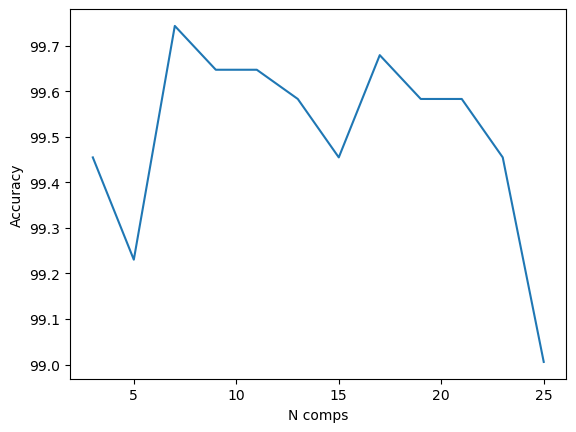

In [9]:
plt.plot(comps_to_try, accs)
plt.xlabel('N comps')
plt.ylabel('Accuracy')
# task is too easy?
# will need to standardize all inputs to have the same neuron size if going for comparison between animals

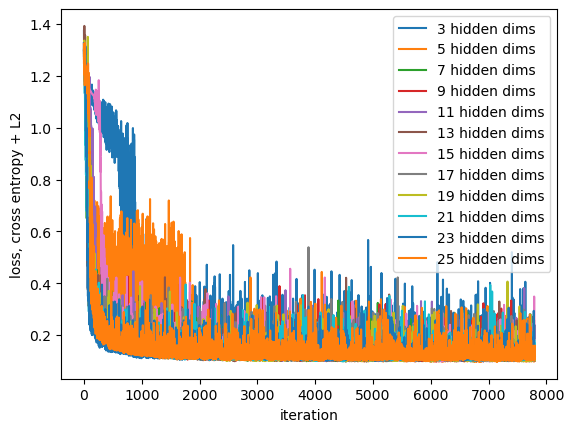

In [12]:
for i, loss_list in enumerate(losses):
    plt.plot(loss_list, label = f'{comps_to_try[i]} hidden dims') 
    plt.xlabel('iteration')
    plt.ylabel('loss, cross entropy + L2')

plt.legend()
plt.show()

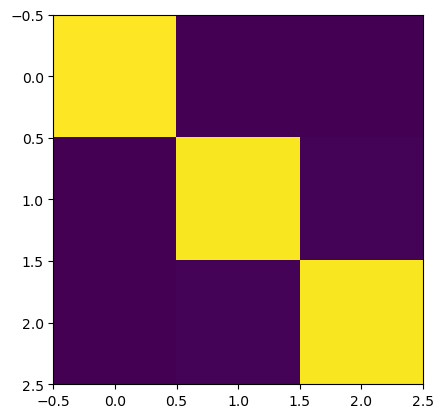

In [ ]:
from sklearn.metrics import confusion_matrix

plt.imshow(confusion_matrix(real_labels, predicted_labels, normalize = 'true'))

In [ ]:
confusion_matrix(real_labels, predicted_labels)

array([[ 717,    0,    0],
       [   0, 1205,   11],
       [   0,   12, 1173]])

In [ ]:
# #save model for the future in case
# with open('models/cnn_model_3cat99acc.pkl', 'wb') as f:
#     pickle.dump(model, f)

In [ ]:
for i, layer in enumerate(model.parameters()):
    print(f'layer {i} num of params: {torch.numel(layer)}')

layer 0 num of params: 576
layer 1 num of params: 64
layer 2 num of params: 18432
layer 3 num of params: 32
layer 4 num of params: 12000
layer 5 num of params: 5
layer 6 num of params: 15
layer 7 num of params: 3
